In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
# Loading the datasets
folder_path = './Dataset Files/'

customers_df = pd.read_csv(folder_path + 'Customers.csv')
products_df = pd.read_csv(folder_path + 'Products.csv')
transactions_df = pd.read_csv(folder_path + 'Transactions.csv')

In [20]:
# Convert date columns to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

In [21]:
customer_features = transactions_df.groupby('CustomerID').agg({
    'TotalValue': ['mean', 'sum', 'std'],
    'Quantity': ['sum', 'mean'],
    'ProductID': 'count'
}).reset_index()

# Flatten column names
customer_features.columns = ['CustomerID', 'avg_spend', 'total_spend', 'std_spend', 
                             'total_quantity', 'avg_quantity', 'transaction_count']

In [22]:
# Add Customer Region
region_dummies = pd.get_dummies(customers_df['Region'], prefix='region')
customer_features = pd.merge(customer_features, customers_df[['CustomerID']], on='CustomerID')
customer_features = pd.concat([customer_features, region_dummies], axis=1)

# handle missing values
customer_features = customer_features.fillna(0)

In [23]:
# Standardize Features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_columns = customer_features.columns.drop('CustomerID')
scaled_features = scaler.fit_transform(customer_features[feature_columns])

In [24]:
# Compute Similarity Matrix
similarity_matrix = cosine_similarity(scaled_features)
customer_indices = {cust_id: idx for idx, cust_id in enumerate(customer_features['CustomerID'])}

In [25]:
# Find Lookalikes
def get_top_3_lookalikes(customer_id):
    if customer_id not in customer_indices:
        return []
    idx = customer_indices[customer_id]
    similarities = similarity_matrix[idx]
    similar_indices = np.argsort(similarities)[::-1][1:4]
    return [(customer_features.iloc[i]['CustomerID'], similarities[i]) for i in similar_indices]

In [26]:
# Recommendations for First 20 Customers
results = []
for cust_id in customer_features['CustomerID'][:20]:
    similar_customers = get_top_3_lookalikes(cust_id)
    results.append({
        'CustomerID': cust_id,
        'CustomerID_Similar1': similar_customers[0][0],
        'Similar1_Score': similar_customers[0][1],
        'CustomerID_Similar2': similar_customers[1][0],
        'Similar2_Score': similar_customers[1][1],
        'CustomerID_Similar3': similar_customers[2][0],
        'Similar3_Score': similar_customers[2][1]
    })

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

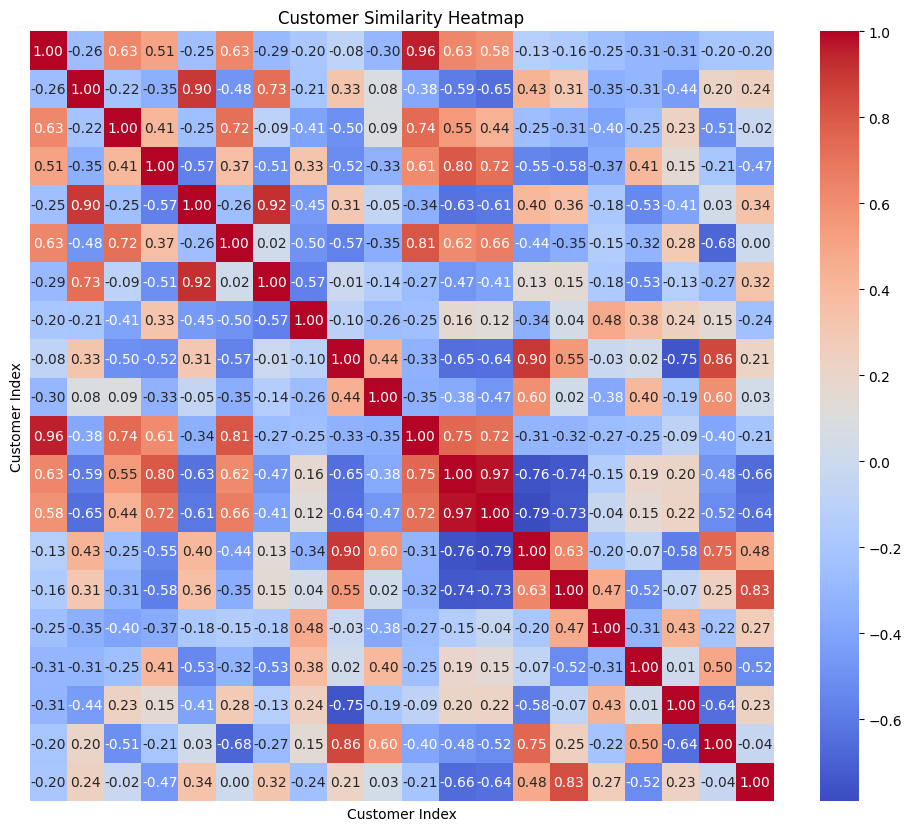

In [28]:
# Visualization
subset_size = 20  # You can adjust this size
similarity_subset = similarity_matrix[:subset_size, :subset_size]

plt.figure(figsize=(12, 10))
sns.heatmap(similarity_subset, cmap='coolwarm', annot=True, fmt=".2f", xticklabels=False, yticklabels=False)
plt.title('Customer Similarity Heatmap')
plt.xlabel('Customer Index')
plt.ylabel('Customer Index')
plt.show()

In [31]:
# Save
lookalike_df = pd.DataFrame(results)
lookalike_df.to_csv('Saurabh_Mahapatra_Lookalike.csv', index=False)

In [32]:
print(lookalike_df.head())

  CustomerID CustomerID_Similar1  Similar1_Score CustomerID_Similar2  \
0      C0001               C0107        0.973176               C0011   
1      C0002               C0043        0.909053               C0056   
2      C0003               C0091        0.840132               C0193   
3      C0004               C0102        0.954264               C0113   
4      C0005               C0146        0.952609               C0177   

   Similar2_Score CustomerID_Similar3  Similar3_Score  
0        0.957606               C0191        0.950875  
1        0.904041               C0005        0.899108  
2        0.830136               C0129        0.803263  
3        0.920428               C0104        0.903858  
4        0.950162               C0007        0.916744  
